In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as mtri
import pandas as pd
import torch

# Physical constants
L, W = 1.0, 0.5    # domain size (cm)
lambda_, mu = 5e9, 5e9  # elastic constants (Pa)
h = 1.0            # thickness (cm)
sf = 1e9           # stress scaling

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # now outputs: u_x, u_y, E_xx, E_yy, E_xy
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )

    def forward(self, x, y):
        # normalize into [-1,1]
        xi  = 2.0 * x / L
        eta = 2.0 * y / W

        raw = self.net(torch.cat([xi, eta], dim=1))
        return raw

In [9]:
# compute true displacement gradients and small‐strain tensor via autograd
def strain_tensor(u_net, v_net, x, y):
    # ∂u/∂x, ∂u/∂y
    u_x_true = torch.autograd.grad(u_net, x,
                    grad_outputs=torch.ones_like(u_net),
                    retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y,
                    grad_outputs=torch.ones_like(u_net),
                    retain_graph=True, create_graph=True)[0]
    # ∂v/∂x, ∂v/∂y
    v_x_true = torch.autograd.grad(v_net, x,
                    grad_outputs=torch.ones_like(v_net),
                    retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y,
                    grad_outputs=torch.ones_like(v_net),
                    retain_graph=True, create_graph=True)[0]

    # small‐strain components
    Exx = u_x_true
    Eyy = v_y_true
    Exy = 0.5 * (u_y_true + v_x_true)

    return u_x_true, u_y_true, v_x_true, v_y_true, Exx, Eyy, Exy


In [10]:
# stress from strain (unchanged)
def stress_tensor(Exx, Eyy, Exy):
    TrE = Exx + Eyy
    Sxx = h * ((lambda_/sf) * TrE + 2 * (mu/sf) * Exx)
    Syy = h * ((lambda_/sf) * TrE + 2 * (mu/sf) * Eyy)
    Sxy = h * (2 * (mu/sf) * Exy)
    return Sxx, Syy, Sxy

In [11]:
# FO‐PINN physics loss with six‐output network: [u, v, u_x, u_y, v_x, v_y]
def physics_loss(model, x, y):
    x.requires_grad_(True)
    y.requires_grad_(True)

    out = model(x, y)
    # unpack network outputs
    u_net, v_net, u_x_net, u_y_net, v_x_net, v_y_net = (
        out[:,  i:i+1] for i in range(6)
    )

    # 1) true gradients & strains via autograd
    u_x_true, u_y_true, v_x_true, v_y_true, \
      Exx_true, Eyy_true, Exy_true = strain_tensor(u_net, v_net, x, y)

    # 2) compatibility loss
    w_comp = 1.0
    loss_grad = (
        torch.mean((u_x_net - u_x_true)**2) +
        torch.mean((u_y_net - u_y_true)**2) +
        torch.mean((v_x_net - v_x_true)**2) +
        torch.mean((v_y_net - v_y_true)**2)
    )

    lc = (loss_grad) * w_comp
    
    Exx_net, Eyy_net = u_x_net, v_y_net
    Exy_net = 0.5 * (u_y_net + v_x_net)
    Sxx, Syy, Sxy = stress_tensor(Exx_net, Eyy_net, Exy_net)

    # 4) first‐order PDE residuals
    Sxx_x = torch.autograd.grad(Sxx, x,
                 grad_outputs=torch.ones_like(Sxx),
                 retain_graph=True, create_graph=True)[0]
    Sxy_y = torch.autograd.grad(Sxy, y,
                 grad_outputs=torch.ones_like(Sxy),
                 retain_graph=True, create_graph=True)[0]
    Syy_y = torch.autograd.grad(Syy, y,
                 grad_outputs=torch.ones_like(Syy),
                 retain_graph=True, create_graph=True)[0]
    Sxy_x = torch.autograd.grad(Sxy, x,
                 grad_outputs=torch.ones_like(Sxy),
                 retain_graph=True, create_graph=True)[0]

    rx = Sxx_x + Sxy_y
    ry = Syy_y + Sxy_x
    lpde = torch.mean(rx**2 + ry**2)

    return lpde + lc


In [12]:
# BC loss
def boundary_condition_loss(model, L, W):
    w_A, w_D, w_C, w_B = 1.0, 1.0, 1.0, 1.0 # Weight for each 
                                            # side of the boundary condition
    
    # A: x = -L/2, u=v=0
    y_A = torch.linspace(-W/2, W/2, 500).reshape(-1,1)
    x_A = -L/2 * torch.ones_like(y_A)
    out_A = model(x_A, y_A)
    u_A, v_A = out_A[:,0:1], out_A[:,1:2]
    loss_A = torch.mean(u_A**2 + v_A**2)
    
    # D: x = +L/2, u_x = 0.025L, u_y = 0
    x_D = L/2 * torch.ones_like(y_A)
    out_D = model(x_D, y_A)
    u_D, v_D = out_D[:,2:3], out_D[:,3:4]
    loss_D = torch.mean((u_D - 0.02*L)**2 + v_D**2)
    
    # C: y = -W/2 traction-free -> sigma_yy=0, sigma_xy=0
    x_C = torch.linspace(-L/2, L/2, 200).reshape(-1,1)
    y_C = -W/2 * torch.ones_like(x_C)
    out_C = model(x_C, y_C)
    Exx_C, Eyy_C = out_C[:,2:3], out_C[:,5:6]
    Exy_C = 0.5*(out_C[:,3:4] + out_C[:,4:5])
    _, Syy_C, Sxy_C = stress_tensor(Exx_C, Eyy_C, Exy_C)
    loss_C = torch.mean(Syy_C**2 + Sxy_C**2)
    
    # B: y = +W/2 traction-free -> sigma_yy=0, sigma_xy=0
    y_B = W/2 * torch.ones_like(x_C)
    out_B = model(x_C, y_B)
    Exx_B, Eyy_B = out_B[:,2:3], out_B[:,5:6]
    Exy_B = 0.5*(out_B[:,3:4] + out_B[:,4:5])
    _, Syy_B, Sxy_B = stress_tensor(Exx_B, Eyy_B, Exy_B)
    loss_B = torch.mean(Syy_B**2 + Sxy_B**2)
    return w_A*loss_A + w_D*loss_D + w_C*loss_C + w_B*loss_B

In [13]:
# Load data from CSV and convert to Tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.manual_seed(0)

def load_fea_dataframe(path):
    """Robustly parse COMSOL CSV that has a text preamble."""
    raw = pd.read_csv(path, header=None)
    header_row = None
    for i in range(min(200, len(raw))):
        row = raw.iloc[i].astype(str).tolist()
        if ("X" in row) and ("Y" in row):
            header_row = i
            break
    if header_row is None:
        raise ValueError("Could not locate header row with X,Y.")
    df = pd.read_csv(path, header=header_row).dropna(axis=1, how='all')
    return df

def fea_to_tensors(df, device, dtype):
    """Return dict of torch tensors (None if column is missing)."""
    def maybe(name, reshape=True):
        if name in df.columns:
            a = torch.tensor(df[name].to_numpy(), dtype=dtype, device=device)
            return a.view(-1,1) if reshape else a
        return None

    tens = {
        "X":   maybe("X"),
        "Y":   maybe("Y"),
        "U":   maybe("u1 (cm)"),
        "V":   maybe("u2 (cm)"),
        "E11": maybe("E11 (1)"),
        "E22": maybe("E22 (1)"),
        "E12": maybe("E12 (1)"),
    }
    # filter rows that have X,Y 
    mask = torch.ones(len(df), dtype=torch.bool)
    for k in ("X","Y","U","V"):
        if tens[k] is None:
            raise ValueError(f"CSV missing required column: {k}")
        mask &= ~torch.isnan(tens[k].view(-1))
    for k,v in tens.items():
        tens[k] = v[mask] if v is not None else None
    return tens

class FEADataset(torch.utils.data.Dataset):
    def __init__(self, tens):
        self.t = tens
        self.n = self.t["X"].shape[0]
    def __len__(self): return self.n
    def __getitem__(self, i):
        return {k: (v[i:i+1] if v is not None else None) for k,v in self.t.items()}

def collate_dict(batch_list):
    keys = batch_list[0].keys()
    out = {}
    for k in keys:
        vals = [b[k] for b in batch_list if b[k] is not None]
        out[k] = torch.cat(vals, dim=0) if vals else None
    return out

# --- load CSV file with DATA from COMSOL-
df  = load_fea_dataframe("/Users/murat/Downloads/data.csv")
if "L (cm)" in df.columns: L = float(df["L (cm)"].iloc[0])
if "W (cm)" in df.columns: W = float(df["W (cm)"].iloc[0])

fea_t = fea_to_tensors(df, device, dtype)
train_ds = FEADataset(fea_t)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=2048, shuffle=True, collate_fn=collate_dict)


In [14]:
# supervised data loss
def data_loss_uvE(model, batch, weights=None):
    """
    Supervised loss using CSV pairs at the exact (X,Y).
    weights = {"u":1.0, "E":1.0} 
    """
    if weights is None:
        weights = {"u": 1.0, "E": 1.0}

    Xb, Yb = batch["X"], batch["Y"]
    Ub, Vb = batch["U"], batch["V"]
    E11b, E22b, E12b = batch.get("E11"), batch.get("E22"), batch.get("E12")

    out = model(Xb, Yb)
    u_pred, v_pred, ux_pred, uy_pred, vx_pred, vy_pred = (out[:,i:i+1] for i in range(6))

    loss = torch.zeros(1, device=out.device, dtype=out.dtype)

    # Displacements
    if weights.get("u", 0.0) > 0:
        Lu = torch.mean((u_pred - Ub)**2 + (v_pred - Vb)**2)
        loss = loss + weights["u"] * Lu

    # Strains (if available in CSV)
    if weights.get("E", 0.0) > 0 and (E11b is not None or E22b is not None or E12b is not None):
        terms = []
        if E11b is not None: terms.append((ux_pred - E11b)**2)
        if E22b is not None: terms.append((vy_pred - E22b)**2)
        if E12b is not None:
            e12_pred = 0.5*(uy_pred + vx_pred)
            terms.append((e12_pred - E12b)**2)
        if terms:
            LE = torch.mean(sum(terms))
            loss = loss + weights["E"] * LE

    return loss


In [16]:
def train_pinn_hybrid(model, optimizer, n_epochs, n_points, L, W,
                      train_dl,
                      w_pde=1.0, w_bc=50.0, w_data=1.0,
                      data_weights={"u":1.0, "E":0.0}):
    """
    Hybrid training: physics + BC + data.
    - train_dl: DataLoader over your CSV tensors
    - data_weights: choose what to supervise from CSV
        {"u":1.0, "E":0.0}        -> only displacements
        {"u":1.0, "E":0.5}        -> displacements + strains
    """
    device = next(model.parameters()).device
    history = []

    # iterate over epochs
    data_iter = iter(train_dl)
    for ep in range(n_epochs):
        # --- (1) PDE collocation points (interior) ---
        x = torch.rand(n_points,1, device=device)*L - L/2
        y = torch.rand(n_points,1, device=device)*W - W/2

        lp = physics_loss(model, x, y)             # PDE + compatibility
        lb = boundary_condition_loss(model, L, W)   # BC residuals

        # --- (2) Supervised batch from CSV nodes ---
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(train_dl)
            batch = next(data_iter)

        # (Ensure tensors on same device; if your dataset already puts them on device, this is cheap)
        batch = {k: (v.to(device) if v is not None else None) for k, v in batch.items()}

        ld = data_loss_uvE(model, batch, data_weights)  # your integrated data loss

        # --- (3) Total loss & step ---
        loss = w_pde*lp + w_bc*lb + w_data*ld

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history.append([loss.item(), lp.item(), lb.item(), ld.item()])

        if ep % 500 == 0:
            print(f"[hybrid] ep {ep:5d} | total {loss.item():.3e} | pde {lp.item():.3e} | bc {lb.item():.3e} | data {ld.item():.3e}")

    return history

In [17]:
# initialize and run
model     = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10000
n_points = 1000
loss_history = train_pinn(model, optimizer, n_epochs, n_points, L, W)

Epoch     0 │ Total: 6.767e+01 │ PDE+comp: 1.180e+00 │ BC: 1.330e+00
Epoch   500 │ Total: 5.998e-04 │ PDE+comp: 4.628e-04 │ BC: 2.740e-06
Epoch  1000 │ Total: 2.446e-04 │ PDE+comp: 1.907e-04 │ BC: 1.078e-06
Epoch  1500 │ Total: 1.288e-04 │ PDE+comp: 1.010e-04 │ BC: 5.560e-07
Epoch  2000 │ Total: 7.602e-05 │ PDE+comp: 5.708e-05 │ BC: 3.789e-07
Epoch  2500 │ Total: 5.226e-05 │ PDE+comp: 3.910e-05 │ BC: 2.630e-07
Epoch  3000 │ Total: 7.535e-05 │ PDE+comp: 3.007e-05 │ BC: 9.055e-07
Epoch  3500 │ Total: 3.778e-05 │ PDE+comp: 2.382e-05 │ BC: 2.792e-07
Epoch  4000 │ Total: 1.269e-04 │ PDE+comp: 1.947e-05 │ BC: 2.150e-06
Epoch  4500 │ Total: 3.242e-05 │ PDE+comp: 2.160e-05 │ BC: 2.164e-07
Epoch  5000 │ Total: 5.617e-05 │ PDE+comp: 1.745e-05 │ BC: 7.743e-07
Epoch  5500 │ Total: 1.063e-04 │ PDE+comp: 3.195e-05 │ BC: 1.488e-06
Epoch  6000 │ Total: 1.541e-04 │ PDE+comp: 2.402e-05 │ BC: 2.602e-06
Epoch  6500 │ Total: 4.426e-05 │ PDE+comp: 2.005e-05 │ BC: 4.842e-07
Epoch  7000 │ Total: 1.720e-02 │ P

In [18]:
torch.save(model.state_dict(), "data_driven_pinn_elasticity.pth")
print("✅ Model weights saved to data_driven_pinn_elasticity.pth")

✅ Model weights saved to data_driven_pinn_elasticity.pth


Mean % error in u: 5.28%
Mean % error in v: 67.85%


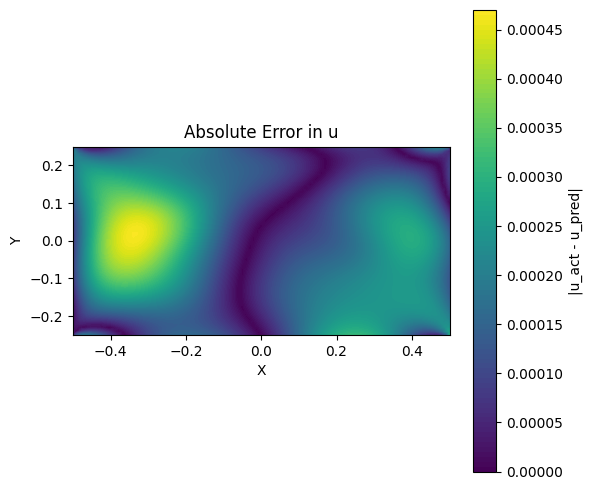

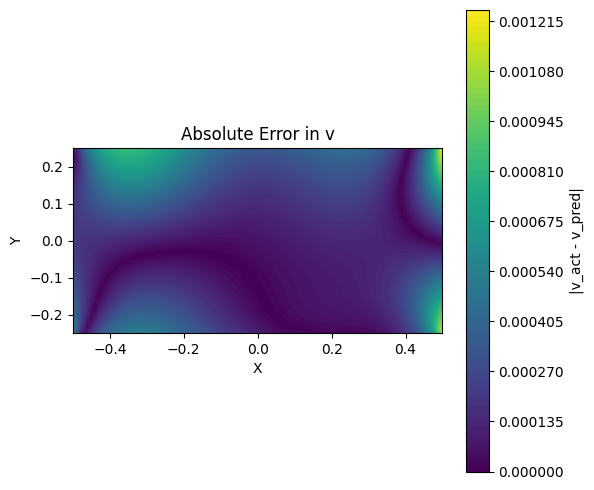

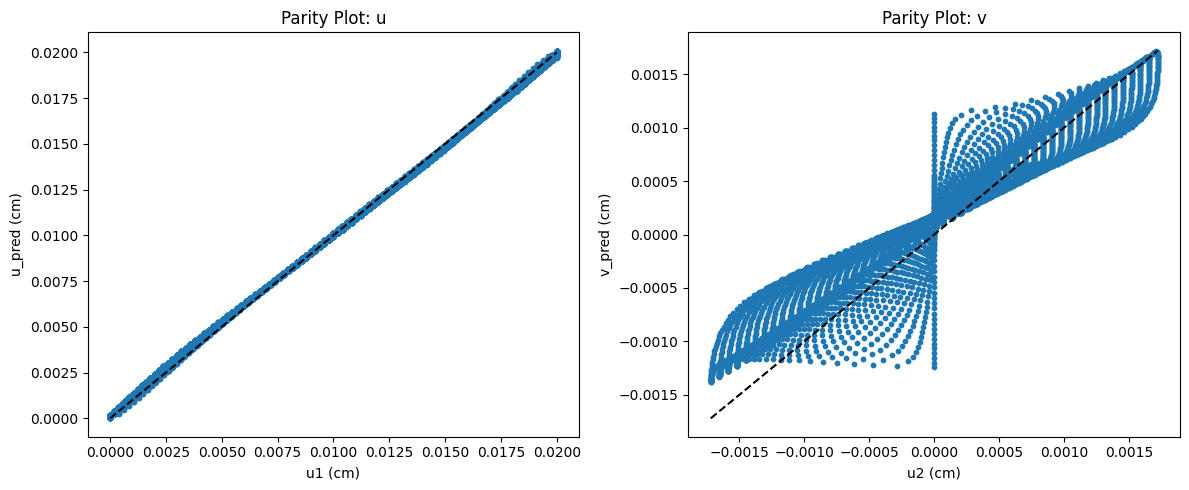

In [19]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# ─── 1) Define PINN Architecture ─────────────────────────────────────────────
L, W = 1.0, 0.5

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )

    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))

# ─── 2) Load Trained Weights ─────────────────────────────────────────────────
model = PINN()
state = torch.load("data_driven_pinn_elasticity.pth", map_location="cpu", weights_only=True)
model.load_state_dict(state)
model.eval()

# ─── 3) Load and Clean COMSOL CSV ────────────────────────────────────────────
csv_path = '/Users/murat/Downloads/data.csv'  # keep filename unchanged
# Read CSV, skip lines starting with '%'
df = pd.read_csv(csv_path, comment='%')
# Clean column names: strip whitespace and leading '%'
df.columns = df.columns.str.strip().str.lstrip('%').str.strip()

# Columns should now be: X, Y, u1 (cm), u2 (cm), ...
X = df['X'].values
Y = df['Y'].values
u_act = df['u1 (cm)'].values  # actual u-displacement (cm)
v_act = df['u2 (cm)'].values  # actual v-displacement (cm)

# ─── 4) Prepare Input Tensors ───────────────────────────────────────────────
x_t = torch.tensor(X, dtype=torch.float32).reshape(-1,1)
y_t = torch.tensor(Y, dtype=torch.float32).reshape(-1,1)

# ─── 5) Forward Pass: Predict u, v ─────────────────────────────────────────
out = model(x_t, y_t)
# network outputs: [u_pred, v_pred, u_x, u_y, v_x, v_y]
u_pred = out[:,0].detach().numpy().flatten()
v_pred = out[:,1].detach().numpy().flatten()

df['u_pred'] = u_pred  # predicted u (cm)
df['v_pred'] = v_pred  # predicted v (cm)

# ─── 6) Compute Absolute & Percent Errors ───────────────────────────────────
df['err_u'] = np.abs(u_act - df['u_pred'])
df['err_v'] = np.abs(v_act - df['v_pred'])

df['pct_err_u'] = np.where(
    np.isclose(u_act, 0),
    0,
    df['err_u'] / np.abs(u_act) * 100
)
df['pct_err_v'] = np.where(
    np.isclose(v_act, 0),
    0,
    df['err_v'] / np.abs(v_act) * 100
)

# ─── 7) Display Percent Errors ───────────────────────────────────────────────
print(f"Mean % error in u: {df['pct_err_u'].mean():.2f}%")
print(f"Mean % error in v: {df['pct_err_v'].mean():.2f}%")

# ─── 8) Plotting Helpers ───────────────────────────────────────────────────
triang = mtri.Triangulation(X, Y)
def plot_contour(field, title, units=''):
    fig, ax = plt.subplots(figsize=(6,5))
    cf = ax.tricontourf(triang, field, levels=100, cmap='viridis')
    fig.colorbar(cf, ax=ax, label=units)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

# ─── 9) Visualize Absolute Errors ───────────────────────────────────────────
plot_contour(df['err_u'], 'Absolute Error in u', '|u_act - u_pred|')
plot_contour(df['err_v'], 'Absolute Error in v', '|v_act - v_pred|')

# ─── 10) Parity Plots ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(df['u1 (cm)'], df['u_pred'], s=10)
axes[0].plot([
    df['u1 (cm)'].min(), df['u1 (cm)'].max()
], [
    df['u1 (cm)'].min(), df['u1 (cm)'].max()
], 'k--')
axes[0].set_xlabel('u1 (cm)')
axes[0].set_ylabel('u_pred (cm)')
axes[0].set_title('Parity Plot: u')

axes[1].scatter(df['u2 (cm)'], df['v_pred'], s=10)
axes[1].plot([
    df['u2 (cm)'].min(), df['u2 (cm)'].max()
], [
    df['u2 (cm)'].min(), df['u2 (cm)'].max()
], 'k--')
axes[1].set_xlabel('u2 (cm)')
axes[1].set_ylabel('v_pred (cm)')
axes[1].set_title('Parity Plot: v')

plt.tight_layout()
plt.show()